Version of the model using complete history, derivative matrix and new p+ and p-.

June 7th, 2021

Equations assuming one CS and one US

$M(n+1,\overset{*}{\tau},i,j)=M(n,\overset{*}{\tau},i,j)+\alpha_M(\tilde{f}(t,\overset{*}{\tau},i)-M(n,\overset{*}{\tau},i,j))$

but Marc suggested this instead: $M_{CS}(n+1,\overset{*}{\tau})=M_{CS}(n,\overset{*}{\tau})+1/n(\tilde{f}(\overset{*}{\tau},t^*))$

$p^+(\delta_i)=M(\overset{*}{\tau}_i=\delta_i,i,j)f_{stim}$
where $f_{stim}$ is an indicator function for the stimulus being present (1) or absent (0)

$p^-(\delta)=\exp\left( {\sum_{stim}\sum_i C_{stim}^{US}(\delta_i)\tilde{f}_{stim}(\overset{*}{\tau}_i,t+\delta_i)} \right)$ 

where $\tilde{f}_{stim}(\overset{*}{\tau}_i,t+\delta_i)$ is a translated time cell. Note: this should contain every combination of 2 stimuli, like CS-US, CS-CS, US-CS, US-US.

$C_{CS}^{US}(\delta,n+1)=C_{CS}^{US}(\delta,n)+\alpha \left( \log \frac{p^+(\delta)}{p^-(\delta)} - C_{CS}^{US}(\delta,n) \right)$

For the CR, Marc suggested calculating $p^-(\delta)$ at each time step and using some sort of temporal difference:

$CR(t)=\sum_\delta p^-(\delta,t)-\sum_\delta p^-(\delta,t+\Delta t)$

Note: code is correct as far as I can tell.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import InvLapFunctions as ilf

In [2]:
k=10
ts_ini=0.05
ts_end=600
ts_num=100
ts_nodes=ts_num+2*k

#---construct taustar values without setting c explicitly
c=(ts_end/ts_ini)**(1/(ts_nodes-1))-1
#---

#---construct taustar by setting c
#c=0.1 # enter value (small is best)
#---

ts=ts_ini*(1+c)**np.array(range(ts_nodes))
s=k/ts
Dtothek=np.linalg.matrix_power(ilf.DerivMatrix(s),k)
C_k=np.array((((-1)**k)/math.factorial(k))*(s)**(k+1))
delta=ts
#Ck = ((-1)**k)*(s[:]**(k+1))*(taustars[:]**g)/factorial(k)

In [3]:
# simple CS-US association to test M
Stim_num=2 
CS_US=10 # seconds
US_US=60 # seconds
US_num=100 # number of USs, number of trials will be 1-US_num since the first US is unsignalled
h=0.02 # time step
alpha_M=0.5
alpha_C=0.05

#--duration of simulation
Sim_dur=US_US*2*US_num # seconds
t=np.linspace(0,Sim_dur,round(Sim_dur/h)) # discretized time points
#--

#--stimuli onset vectors (input to temporal context cells)
InputSize=75 # this has a huge effect on p- (100 seems best but experiment)
USt=np.zeros(t.size)
CSt=np.zeros(t.size)

USonset=(np.array(range(US_num))*US_US)/h
CSonset=(np.array(range(1,2*US_num))*US_US-CS_US)/h

USt[USonset.astype(int)]=1
CSt[CSonset.astype(int)]=1
#--

#--initialize M(taustar,Stim_num,Stim_num). M(taustar,A,B) is read as state of stim A time cells at onset of stimulus B 
M=np.ones((ts_num,Stim_num,Stim_num))*(1/4) # index key: US=0, CS1=1, CS2=2, etc. The 1/4 is for 1/(N^2) where N=#stim.
#M_US=np.zeros((ts_num,Stim_num)) # update at US onset, col1=CS, col2=US
#--

#--initialize C(delta,Stim_num,Stim_num). C(delta,A,B) is credit of A given B.
C=np.ones((ts_num,Stim_num,Stim_num)) # index key: US=0, CS1=1, CS2=2, etc.
#C_US=np.ones((ts_num,Stim_num)) # update at US onset, col1=CS, col2=US
#--

#--Temporal and Time cell vectors for each stimulus
#CStempcell=np.zeros((ts_nodes,t.size+1))
#CStimecell=np.zeros((ts_num,t.size+1))

#UStempcell=np.zeros((ts_nodes,t.size+1))
#UStimecell=np.zeros((ts_num,t.size+1))

tempcell=np.zeros((t.size+1,ts_nodes,Stim_num)) # index key for Stim_num dimension: US=0, CS1=1, CS2=2, etc.
ftilde=np.zeros((t.size+1,ts_num,Stim_num)) # index key for Stim_num dimension: US=0, CS1=1, CS2=2, etc.
#--

#--initialize p+ and p-
#p_plus=np.ones((ts_num,t.size))
pminus=np.ones((ts_num,Stim_num,Stim_num))
#--

#--counters and initial values for analytical soln of temp cells when input=0, but not sure if speed improves
counterUS=0
counterCS=0
UStemp_0=tempcell[0,:,0].copy()
CStemp_0=tempcell[0,:,1].copy()
#--

#--initialize CR(t)
CR=np.zeros(t.size)
pminus_CR=np.ones((t.size,ts_num))

for i in range(t.size):
    
    #--update temporal cont and time cells
    counterUS+=1
    tempcell[i+1,:,0]=UStemp_0*np.exp(-s*h*counterUS)
    ftilde[i+1,:,0]=ilf.TimeCell(C_k,tempcell[i,:,0],Dtothek,k)
        
    counterCS+=1
    tempcell[i+1,:,1]=CStemp_0*np.exp(-s*h*counterCS)
    ftilde[i+1,:,1]=ilf.TimeCell(C_k,tempcell[i,:,1],Dtothek,k)
    
    pminus_CR[i,:]=np.exp(C[:,0,1]@ilf.Trans(tempcell[i,:,1],s,delta,C_k,Dtothek,k)+C[:,0,0]@ilf.Trans(tempcell[i,:,0],s,delta,C_k,Dtothek,k))
    CR[i]=np.sum(pminus_CR[i,:])
    
    if USt[i]==1: # US is presented
        
        #--update temporal context cells
        tempcell[i+1,:,0]=ilf.TempContCell(h,tempcell[i,:,0],USt[i]*InputSize,s)
        #ftilde[i+1,:,0]=ilf.TimeCell(C_k,tempcell[i,:,0],Dtothek,k)
        #--
        
        #--reset counter and initial state for temp context cells
        counterUS=0
        UStemp_0=tempcell[i+1,:,0].copy()
        #--
        
        #--update C(delta,US,US): prediction of US given US
        p_plus=M[:,0,0].copy()
        p_plus[p_plus<1e-20]=1e-20
        
        #pminus=np.exp(C[:,0,0]@ilf.Trans(tempcell[i,:,0],s,delta,C_k,Dtothek,k)) # make sure you translate temp cont cell at i (before input)
        pminus[:,0,0]=np.exp(C[:,0,0]@ilf.Trans(tempcell[i,:,0],s,delta,C_k,Dtothek,k)+C[:,0,1]@ilf.Trans(tempcell[i,:,1],s,delta,C_k,Dtothek,k)) # make sure you translate temp cont cell at i (before input)
        pminus[pminus<1e-20]=1e-20
        
        #C[:,0,0]=C[:,0,0]+alpha_C*(np.log(p_plus/pminus[:,0,0])-C[:,0,0])
        C[:,0,0]=C[:,0,0]+alpha_C*(np.log(p_plus)-np.log(pminus[:,0,0])-C[:,0,0])
        #--
        
        #--update C(delta,CS,US): prediction of CS given US
        p_plus=M[:,0,1].copy()
        p_plus[p_plus<1e-20]=1e-20
        
        pminus[:,1,0]=np.exp(C[:,1,0]@ilf.Trans(tempcell[i,:,0],s,delta,C_k,Dtothek,k)+C[:,1,1]@ilf.Trans(tempcell[i,:,1],s,delta,C_k,Dtothek,k)) # make sure you translate temp cont cell at i (before input)
        pminus[pminus<1e-20]=1e-20
        
        #C[:,1,0]=C[:,1,0]+alpha_C*(np.log(p_plus/pminus[:,1,0])-C[:,1,0])
        C[:,1,0]=C[:,1,0]+alpha_C*(np.log(p_plus)-np.log(pminus[:,1,0])-C[:,1,0])
        #--
        
        #--update M(taustar,CS,US) and M(taustar,US,US)
#         M[:,0,0]=M[:,0,0]+alpha_M*(ftilde[i,:,0]-M[:,0,0])
#         M[:,1,0]=M[:,1,0]+alpha_M*(ftilde[i,:,1]-M[:,1,0])
        M[:,:,0]=M[:,:,0]+alpha_M*(ftilde[i,:,:]-M[:,:,0])
        #--
        
    elif CSt[i]==1: # CS is presented
        
        #--update temporal context cells
        tempcell[i+1,:,1]=ilf.TempContCell(h,tempcell[i,:,1],CSt[i]*InputSize,s)
        #ftilde[i+1,:,1]=ilf.TimeCell(C_k,tempcell[i,:,1],Dtothek,k)
        #--
        
        #--reset counter and initial state for temp context cells
        counterCS=0
        CStemp_0=tempcell[i+1,:,1].copy()
        #--
        
        #--update C(delta,US,CS): prediction of US given CS
        p_plus=M[:,1,0].copy()
        p_plus[p_plus<1e-20]=1e-20
        
        pminus[:,0,1]=np.exp(C[:,0,1]@ilf.Trans(tempcell[i,:,1],s,delta,C_k,Dtothek,k)+C[:,0,0]@ilf.Trans(tempcell[i,:,0],s,delta,C_k,Dtothek,k)) # make sure you translate temp cont cell at i (before input)
        pminus[pminus<1e-20]=1e-20
        
        #C[:,0,1]=C[:,0,1]+alpha_C*(np.log(p_plus/pminus[:,0,1])-C[:,0,1])
        C[:,0,1]=C[:,0,1]+alpha_C*(np.log(p_plus)-np.log(pminus[:,0,1])-C[:,0,1])
        #--
        
        #--update C(delta,CS,CS): prediction of CS given CS
        p_plus=M[:,1,1].copy()
        p_plus[p_plus<1e-20]=1e-20
        
        pminus[:,1,1]=np.exp(C[:,1,1]@ilf.Trans(tempcell[i,:,1],s,delta,C_k,Dtothek,k)+C[:,1,0]@ilf.Trans(tempcell[i,:,0],s,delta,C_k,Dtothek,k)) # make sure you translate temp cont cell at i (before input)
        pminus[pminus<1e-20]=1e-20
        
        #C[:,1,1]=C[:,1,1]+alpha_C*(np.log(p_plus/pminus[:,1,1])-C[:,1,1])
        C[:,1,1]=C[:,1,1]+alpha_C*(np.log(p_plus)-np.log(pminus[:,1,1])-C[:,1,1])
        #--
        
        #--update M(taustar,CS,CS) and M(taustar,US,CS)
        M[:,:,1]=M[:,:,1]+alpha_M*(ftilde[i,:,:]-M[:,:,1])
        #--

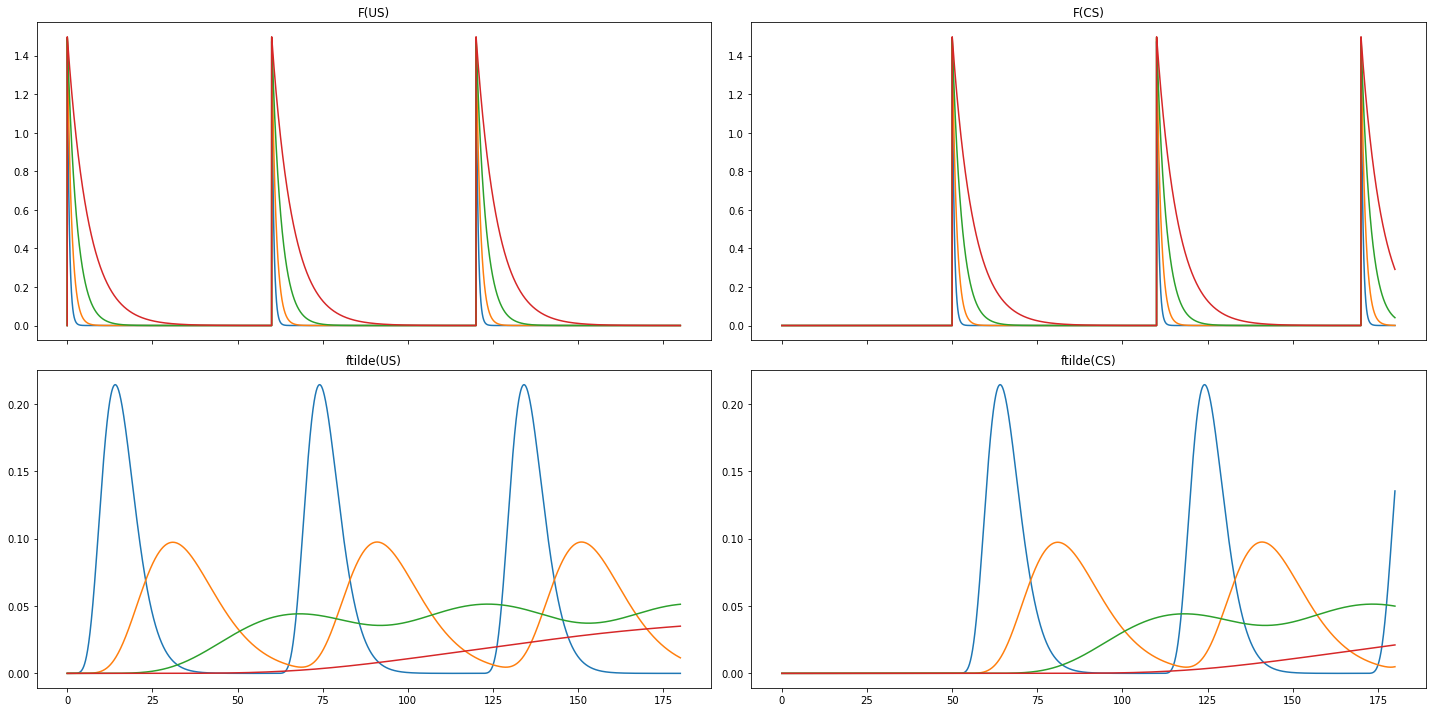

In [4]:
sta=0
end=9000
taustar_ini=k+50
taustar_end=k+90
fig3, axs3 = plt.subplots(2,2,sharex=True, figsize=(20,10))
axs3[0,0].set_title('F(US)')
axs3[0,0].plot(t[sta:end],tempcell[sta:end,taustar_ini:taustar_end:10,0])
axs3[1,0].set_title('ftilde(US)')
axs3[1,0].plot(t[sta:end],ftilde[sta:end,taustar_ini:taustar_end:10,0])
axs3[0,1].set_title('F(CS)')
axs3[0,1].plot(t[sta:end],tempcell[sta:end,taustar_ini:taustar_end:10,1])
axs3[1,1].set_title('ftilde(CS)')
axs3[1,1].plot(t[sta:end],ftilde[sta:end,taustar_ini:taustar_end:10,1])
fig3.tight_layout()

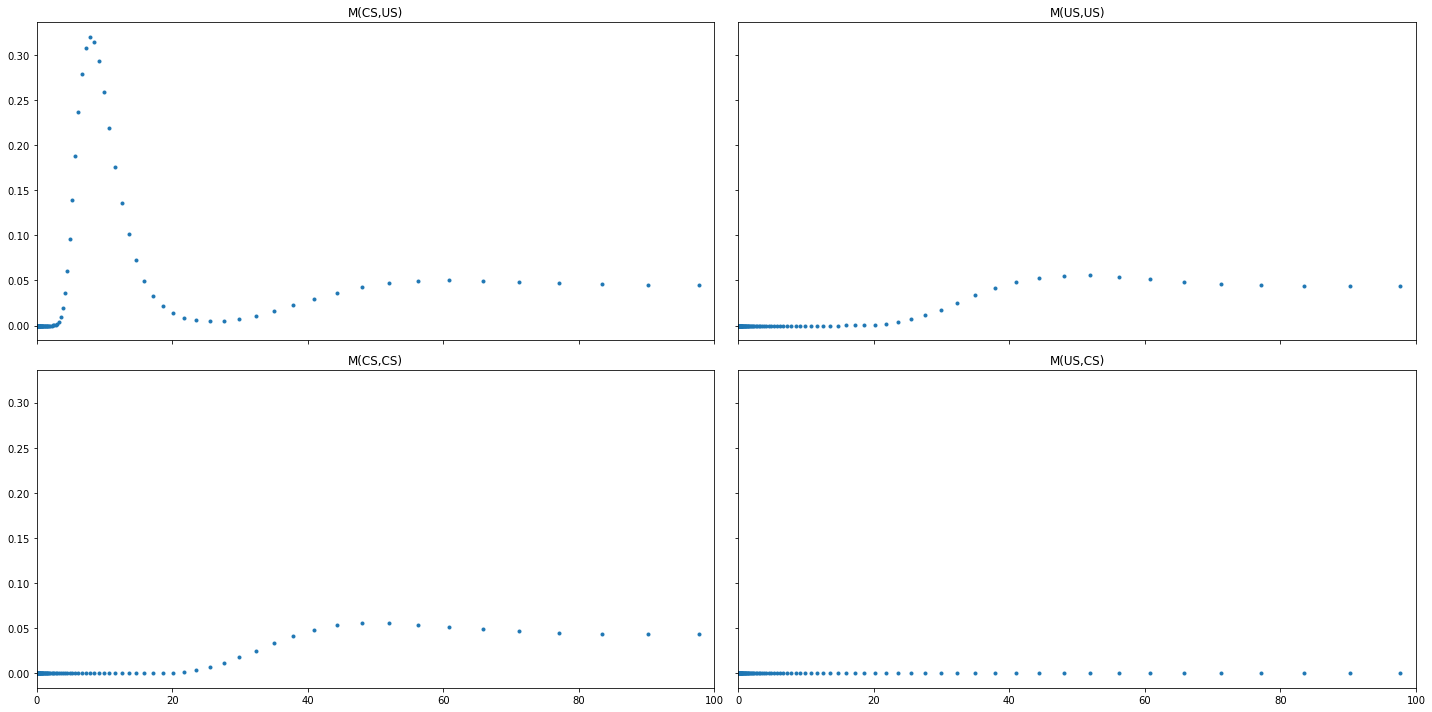

In [5]:
fig2, axs2 = plt.subplots(2,2,sharex=True,sharey=True, figsize=(20,10))
axs2[0,0].set_title('M(CS,US)')
axs2[0,0].plot(ts[k:-k],M[:,1,0],'.')
axs2[1,0].set_title('M(CS,CS)')
axs2[1,0].plot(ts[k:-k],M[:,1,1],'.')
axs2[1,0].set_xlim([0, 100])
axs2[0,1].set_title('M(US,US)')
axs2[0,1].plot(ts[k:-k],M[:,0,0],'.')
axs2[1,1].set_title('M(US,CS)')
axs2[1,1].plot(ts[k:-k],M[:,0,1],'.')
fig2.tight_layout()

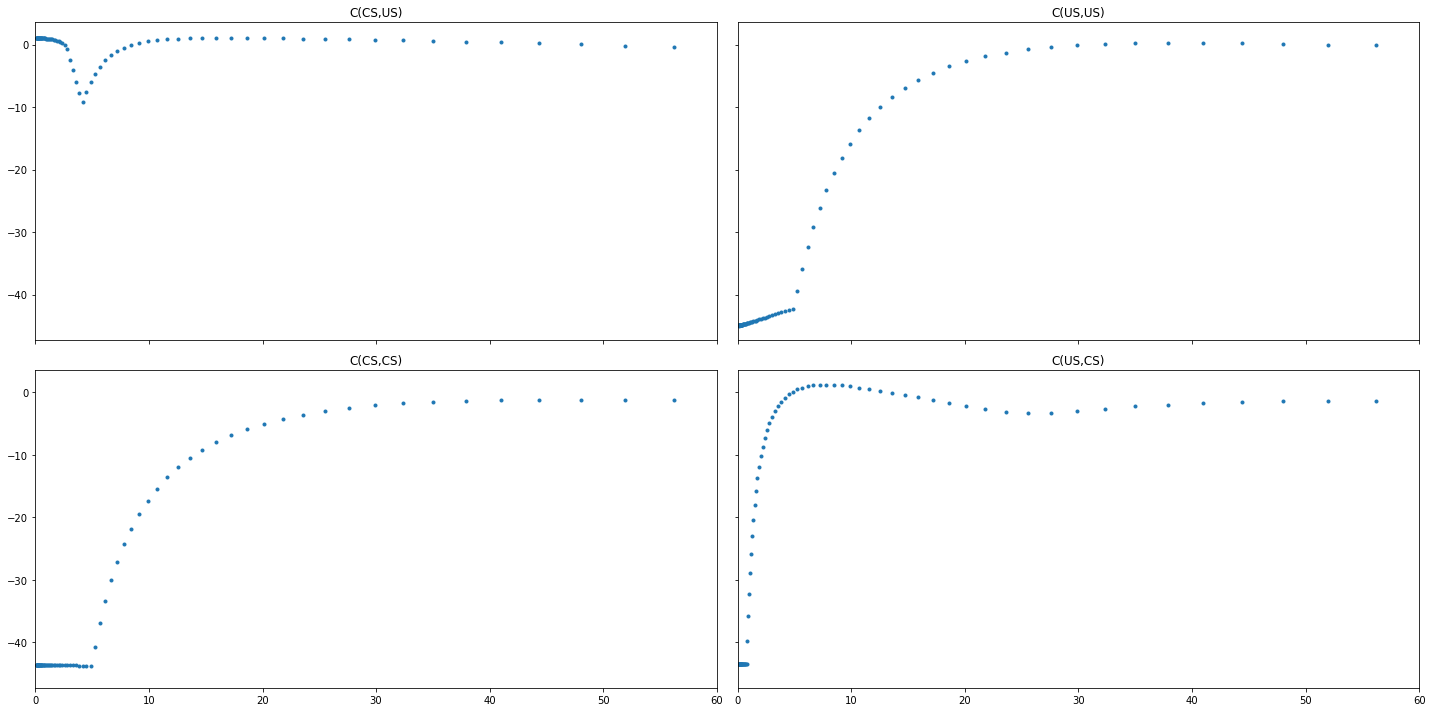

In [6]:
fig1, axs1 = plt.subplots(2,2,sharex=True,sharey=True,figsize=(20,10))
axs1[0,0].plot(delta[k:-k],C[:,1,0],'.')
axs1[0,0].set_title('C(CS,US)')
axs1[1,0].plot(delta[k:-k],C[:,1,1],'.')
axs1[1,0].set_xlim([0, 60])
axs1[1,0].set_title('C(CS,CS)')
axs1[0,1].plot(delta[k:-k],C[:,0,0],'.')
axs1[0,1].set_title('C(US,US)')
axs1[1,1].plot(delta[k:-k],C[:,0,1],'.')
axs1[1,1].set_title('C(US,CS)')
fig1.tight_layout()

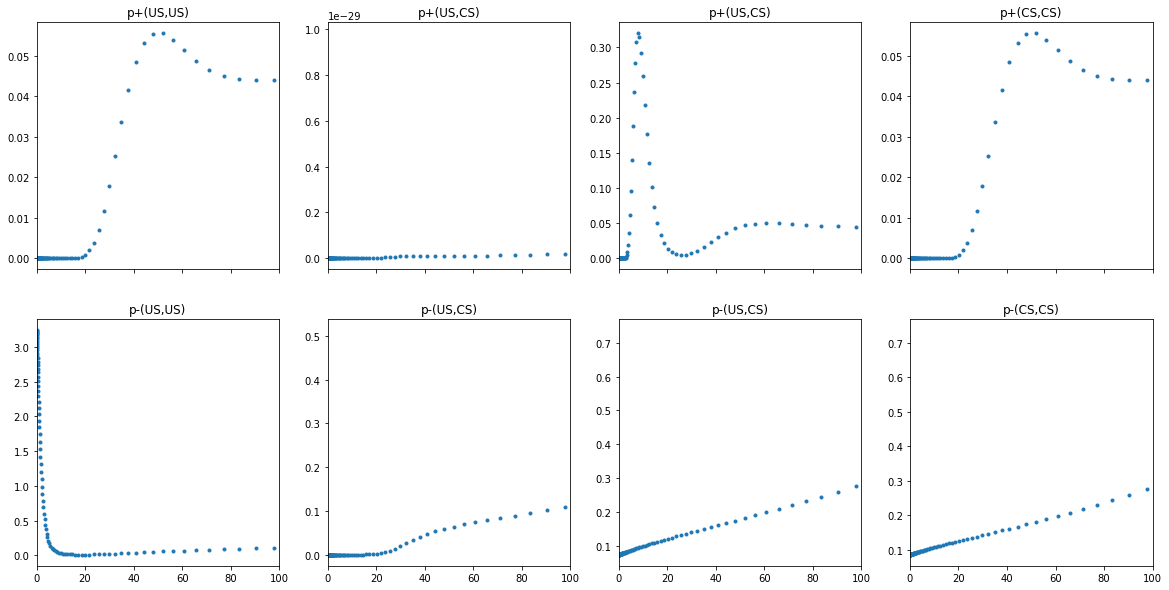

In [7]:
fig4, axs4 = plt.subplots(2,4,sharex=True,figsize=(20,10))
axs4[0,0].set_title('p+(US,US)')
axs4[0,0].plot(ts[k:-k],M[:,0,0],'.')
axs4[1,0].set_title('p-(US,US)')
axs4[1,0].plot(delta[k:-k],pminus[:,0,0],'.')

axs4[0,1].set_title('p+(US,CS)')
axs4[0,1].plot(ts[k:-k],M[:,0,1],'.')
axs4[1,1].set_title('p-(US,CS)')
axs4[1,1].plot(delta[k:-k],pminus[:,1,0],'.')

axs4[0,2].set_title('p+(US,CS)')
axs4[0,2].plot(ts[k:-k],M[:,1,0],'.')
axs4[1,2].set_title('p-(US,CS)')
axs4[1,2].plot(delta[k:-k],pminus[:,0,1],'.')

axs4[0,3].set_title('p+(CS,CS)')
axs4[0,3].plot(ts[k:-k],M[:,1,1],'.')
axs4[1,3].set_title('p-(CS,CS)')
axs4[1,3].plot(delta[k:-k],pminus[:,1,1],'.')
axs4[1,3].set_xlim([0, 100])

fig1.tight_layout()

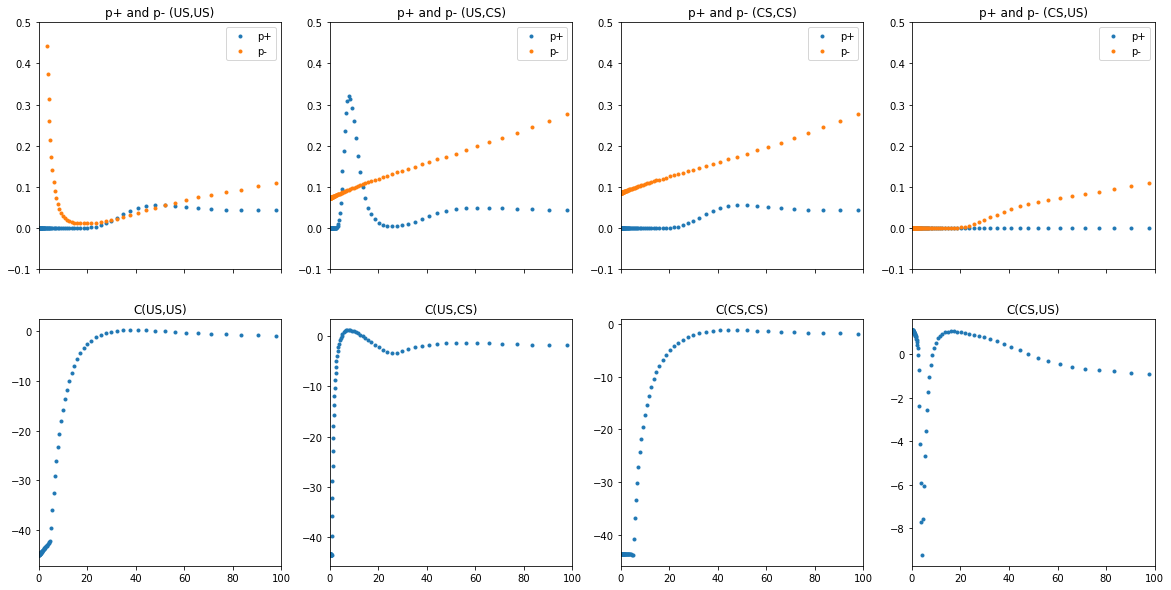

In [8]:
fig5, axs5 = plt.subplots(2,4,sharex=True,figsize=(20,10))
axs5[0,0].set_title('p+ and p- (US,US)')
axs5[0,0].plot(ts[k:-k],M[:,0,0],'.',label='p+')
axs5[0,0].plot(ts[k:-k],pminus[:,0,0],'.',label='p-')
axs5[0,0].set_ylim([-0.1,0.5])
axs5[0,0].legend()
axs5[1,0].set_title('C(US,US)')
axs5[1,0].plot(delta[k:-k],C[:,0,0],'.')
#axs5[1,0].set_ylim([0,0.5])

axs5[0,1].set_title('p+ and p- (US,CS)')
axs5[0,1].plot(ts[k:-k],M[:,1,0],'.',label='p+')
axs5[0,1].plot(ts[k:-k],pminus[:,0,1],'.',label='p-')
axs5[0,1].set_ylim([-0.1,0.5])
axs5[0,1].legend()
axs5[1,1].set_title('C(US,CS)')
axs5[1,1].plot(delta[k:-k],C[:,0,1],'.')
#axs5[1,1].set_ylim([0,2])

axs5[0,2].set_title('p+ and p- (CS,CS)')
axs5[0,2].plot(ts[k:-k],M[:,1,1],'.',label='p+')
axs5[0,2].plot(ts[k:-k],pminus[:,1,1],'.',label='p-')
axs5[0,2].set_ylim([-0.1,0.5])
axs5[0,2].legend()
axs5[1,2].set_title('C(CS,CS)')
axs5[1,2].plot(delta[k:-k],C[:,1,1],'.')
#axs5[1,2].set_ylim([-0.5,0])

axs5[0,3].set_title('p+ and p- (CS,US)')
axs5[0,3].plot(ts[k:-k],M[:,0,1],'.',label='p+')
axs5[0,3].plot(ts[k:-k],pminus[:,1,0],'.',label='p-')
axs5[0,3].set_ylim([-0.1,0.5])
axs5[0,3].legend()
axs5[1,3].set_title('C(CS,US)')
axs5[1,3].plot(delta[k:-k],C[:,1,0],'.')
#axs5[1,3].set_ylim([-0.5,0])


# axs4[0,1].set_title('p+(CS,US)')
# axs4[0,1].plot(ts[k:-k],M[:,0,1],'.')
# axs4[1,1].set_title('p-(CS,US)')
# axs4[1,1].plot(delta[k:-k],pminus[:,1,0],'.')

# axs4[0,2].set_title('p+(US,CS)')
# axs4[0,2].plot(ts[k:-k],M[:,1,0],'.')
# axs4[1,2].set_title('p-(US,CS)')
# axs4[1,2].plot(delta[k:-k],pminus[:,0,1],'.')

# axs4[0,3].set_title('p+(CS,CS)')
# axs4[0,3].plot(ts[k:-k],M[:,1,1],'.')
# axs4[1,3].set_title('p-(CS,CS)')
# axs4[1,3].plot(delta[k:-k],pminus[:,1,1],'.')
axs5[1,3].set_xlim([0, 100])

fig1.tight_layout()


(0.0, 100.0)

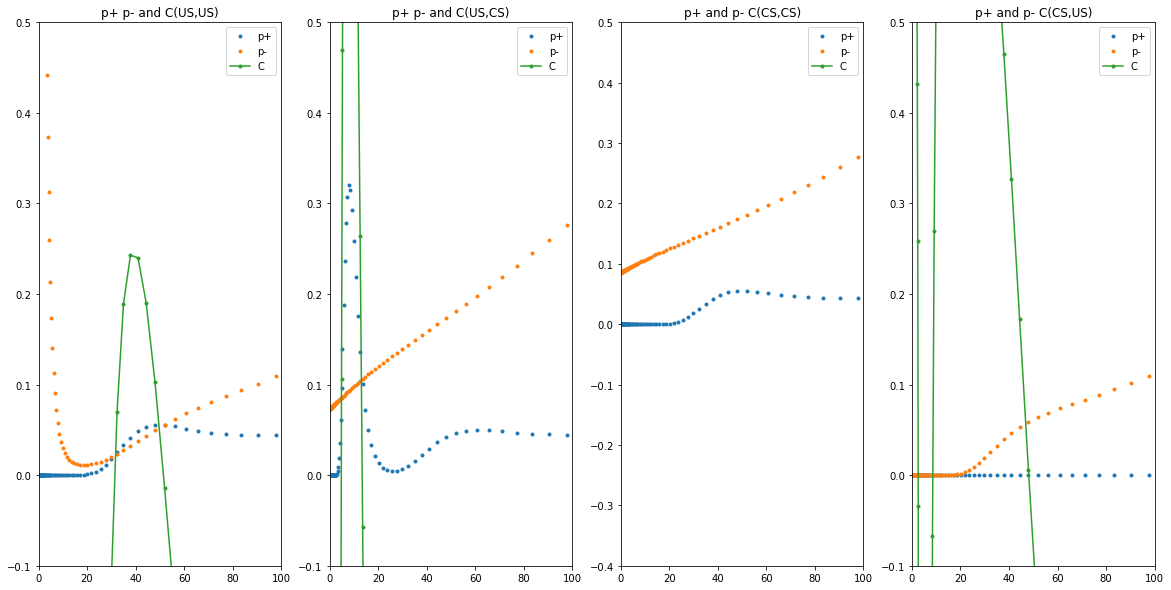

In [9]:
fig5, axs5 = plt.subplots(1,4,sharex=True,figsize=(20,10))
axs5[0].set_title('p+ p- and C(US,US)')
axs5[0].plot(ts[k:-k],M[:,0,0],'.',label='p+')
axs5[0].plot(ts[k:-k],pminus[:,0,0],'.',label='p-')
axs5[0].plot(delta[k:-k],C[:,0,0],'.-', label='C')
axs5[0].set_ylim([-0.1,0.5])
axs5[0].legend()

axs5[1].set_title('p+ p- and C(US,CS)')
axs5[1].plot(ts[k:-k],M[:,1,0],'.',label='p+')
axs5[1].plot(ts[k:-k],pminus[:,0,1],'.',label='p-')
axs5[1].plot(delta[k:-k],C[:,0,1],'.-',label='C')
axs5[1].set_ylim([-0.1,0.5])
axs5[1].legend()

axs5[2].set_title('p+ and p- C(CS,CS)')
axs5[2].plot(ts[k:-k],M[:,1,1],'.',label='p+')
axs5[2].plot(ts[k:-k],pminus[:,1,1],'.',label='p-')
axs5[2].plot(delta[k:-k],C[:,1,1],'.-',label='C')
axs5[2].set_ylim([-0.4,0.5])
axs5[2].legend()

axs5[3].set_title('p+ and p- C(CS,US)')
axs5[3].plot(ts[k:-k],M[:,0,1],'.',label='p+')
axs5[3].plot(ts[k:-k],pminus[:,1,0],'.',label='p-')
axs5[3].plot(delta[k:-k],C[:,1,0],'.-',label='C')
axs5[3].set_ylim([-0.1,0.5])
axs5[3].legend()
axs5[3].set_xlim([0, 100])

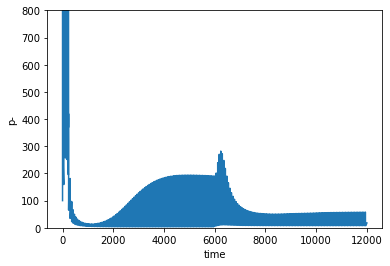

In [23]:
plt.plot(t,CR)
#plt.axvline(x=CSonset[-2]*h,c='g')
#plt.axvline(x=CSonset[-1]*h,c='g')
#plt.axvline(x=CSonset[-1]*h,c='g')
#plt.axvline(x=USonset[-1]*h,c='r')
#plt.xlim([CSonset[-1]*h-5,CSonset[-1]*h+15])
plt.ylim([0,800])
plt.xlabel('time')
plt.ylabel('p-')
plt.savefig('FullSession.pdf')

In [11]:
USonset

array([     0.,   3000.,   6000.,   9000.,  12000.,  15000.,  18000.,
        21000.,  24000.,  27000.,  30000.,  33000.,  36000.,  39000.,
        42000.,  45000.,  48000.,  51000.,  54000.,  57000.,  60000.,
        63000.,  66000.,  69000.,  72000.,  75000.,  78000.,  81000.,
        84000.,  87000.,  90000.,  93000.,  96000.,  99000., 102000.,
       105000., 108000., 111000., 114000., 117000., 120000., 123000.,
       126000., 129000., 132000., 135000., 138000., 141000., 144000.,
       147000., 150000., 153000., 156000., 159000., 162000., 165000.,
       168000., 171000., 174000., 177000., 180000., 183000., 186000.,
       189000., 192000., 195000., 198000., 201000., 204000., 207000.,
       210000., 213000., 216000., 219000., 222000., 225000., 228000.,
       231000., 234000., 237000., 240000., 243000., 246000., 249000.,
       252000., 255000., 258000., 261000., 264000., 267000., 270000.,
       273000., 276000., 279000., 282000., 285000., 288000., 291000.,
       294000., 2970

In [12]:
CSonset

array([  2500.,   5500.,   8500.,  11500.,  14500.,  17500.,  20500.,
        23500.,  26500.,  29500.,  32500.,  35500.,  38500.,  41500.,
        44500.,  47500.,  50500.,  53500.,  56500.,  59500.,  62500.,
        65500.,  68500.,  71500.,  74500.,  77500.,  80500.,  83500.,
        86500.,  89500.,  92500.,  95500.,  98500., 101500., 104500.,
       107500., 110500., 113500., 116500., 119500., 122500., 125500.,
       128500., 131500., 134500., 137500., 140500., 143500., 146500.,
       149500., 152500., 155500., 158500., 161500., 164500., 167500.,
       170500., 173500., 176500., 179500., 182500., 185500., 188500.,
       191500., 194500., 197500., 200500., 203500., 206500., 209500.,
       212500., 215500., 218500., 221500., 224500., 227500., 230500.,
       233500., 236500., 239500., 242500., 245500., 248500., 251500.,
       254500., 257500., 260500., 263500., 266500., 269500., 272500.,
       275500., 278500., 281500., 284500., 287500., 290500., 293500.,
       296500., 2995

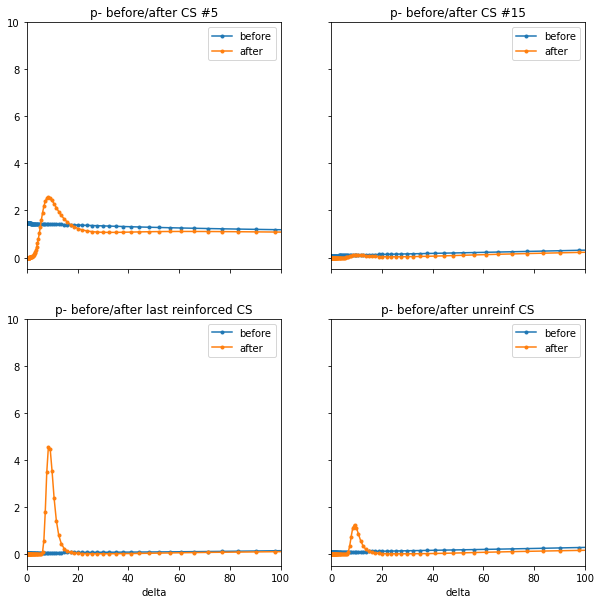

In [25]:
fig6, axs6 = plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,10))
axs6[0,0].set_title('p- before/after CS #5')
axs6[0,0].plot(delta[k:-k],pminus_CR[14500,:],'.-',label='before')
axs6[0,0].plot(delta[k:-k],pminus_CR[14501,:],'.-',label='after')
axs6[0,0].set_ylim([-0.5,10])
axs6[0,0].legend()

axs6[0,1].set_title('p- before/after CS #15')
axs6[0,1].plot(delta[k:-k],pminus_CR[44500,:],'.-',label='before')
axs6[0,1].plot(delta[k:-k],pminus_CR[44501,:],'.-',label='after')
axs6[0,1].set_ylim([-0.5,10])
axs6[0,1].legend()

axs6[1,0].set_title('p- before/after last reinforced CS')
axs6[1,0].plot(delta[k:-k],pminus_CR[296500,:],'.-',label='before')
axs6[1,0].plot(delta[k:-k],pminus_CR[296501,:],'.-',label='after')
axs6[1,0].set_ylim([-0.5,10])
axs6[1,0].legend()
axs6[1,0].set_xlabel('delta')

axs6[1,1].set_title('p- before/after unreinf CS')
axs6[1,1].plot(delta[k:-k],pminus_CR[596500,:],'.-',label='before')
axs6[1,1].plot(delta[k:-k],pminus_CR[596501,:],'.-',label='after')
#axs6[1,1].set_ylim([0,10])
axs6[1,1].legend()
axs6[1,1].set_xlim([0, 100])
axs6[1,1].set_xlabel('delta')

fig6.savefig('PminusBefAfter.pdf')

In [14]:
test=np.ones((2,3))
test_sum=np.sum(test,axis=0)
test_sum

array([2., 2., 2.])

In [15]:
V=U[:,np.newaxis]
V
#np.transpose(U[:,np.newaxis])

NameError: name 'U' is not defined

In [ ]:
TransTempCells.shape

In [ ]:
C_k.shape

In [ ]:
C_k[:,np.newaxis]

In [ ]:
A=np.zeros((2,3,2))

In [ ]:
print(A)

In [ ]:
A.shape

In [ ]:
B=np.array([[1,2,3,4],[5,6,7,8]])

In [ ]:
B.shape

In [ ]:
C=np.array([1,2,3,4])

In [ ]:
C.shape

In [ ]:
C=np.array([[1,2,3,4]])

In [ ]:
x = np.array([[1,2,3],[4,5,6]])

In [ ]:
y=x.copy()

In [ ]:
y[1,0]=0
print(y)

In [ ]:
print(x)